In [64]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

[2.56774873e-19 2.56774873e-19 1.99122555e-12 ...            nan
            nan            nan]
[45. 48.  1.  4.]
500
Epoch 1/1000
10/10 [==============================] - 1s 14ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 2/1000
10/10 [==============================] - 0s 4ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 3/1000
10/10 [==============================] - 0s 5ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 4/1000
10/10 [==============================] - 0s 5ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 5/1000
10/10 [==============================] - 0s 4ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 6/1000
10/10 [==============================] - 0s 4ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 7/1000
10/10 [==============================] - 0s 4ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 8/1000
10/10 [====================

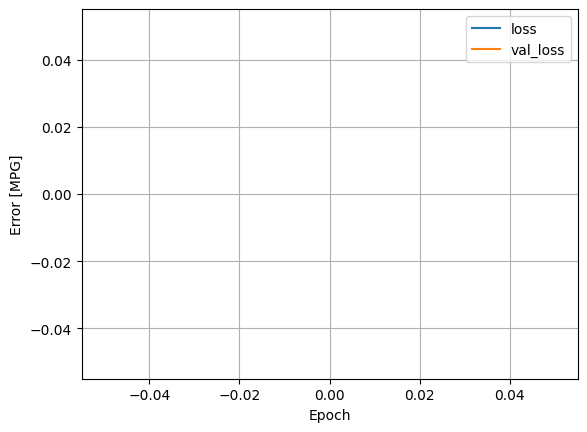

In [68]:
#test.csvの9列目以降のデータから，8列目までのデータを予測する
#dataframeで読み込み
df = pd.read_csv('test2.csv', header=0,)

#dataframeをnumpy配列に変換
data = df.values

#深層学習の入力データと出力データに分ける
# 入力データ

len_test = 4

x = data[:, len_test+1:]
print(x[0])

# 出力データ
y = data[:, 1:len_test+1]
print(y[0])
#入力データの正規化
x = (x - x.mean()) / x.std()

#出力データの正規化
#y = (y - y.mean()) / y.std()

#入力データの次元数
input_dim = x.shape[1]

#出力データの次元数
output_dim = y.shape[1]

#入力データの数
n = x.shape[0]
print(n)

#学習データとテストデータに分ける
#学習データ
x_train = x[:int(n*0.8)]
y_train = y[:int(n*0.8)]

#テストデータ
x_test = x[int(n*0.8):]
y_test = y[int(n*0.8):]

#モデルの定義
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(input_dim,)),
    # ドロップアウト
 #   tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu', input_shape=(input_dim,)),
    #ドロップアウト
   # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
   # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(output_dim)
])

#モデルのコンパイル
model.compile(optimizer='adam',
                loss='mse',
                metrics=['mse'])

#モデルの学習
history = model.fit(x_train, y_train, epochs=1000, batch_size=32, validation_split=0.2)

#学習の様子をグラフに描画
#損失関数の値
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')


plt.xlabel('Epoch')
plt.ylabel('Error [MPG]')

plt.legend()
plt.grid(True)

#表示
plt.show()


In [ ]:
# ハイパーパラメータチューニング

import optuna

def objective(trial):
    # ハイパーパラメータの探索範囲を定義
    n_layers = trial.suggest_int('n_layers', 1, 3)
    layers = []
    for i in range(n_layers):
        n_units = trial.suggest_int('n_units_l{}'.format(i), 4, 128)
        layers.append(tf.keras.layers.Dense(n_units, activation='relu'))
    layers.append(tf.keras.layers.Dense(output_dim))

    model = tf.keras.models.Sequential(layers)

    model.compile(optimizer='adam',
                loss='mse',
                metrics=['mae'])

    history = model.fit(x_train, y_train, epochs=10000, batch_size=32, validation_split=0.2, verbose=0)

    return history.history['val_loss'][-1]

In [ ]:
#1行目の値を実際に計算
print(model.predict(x_test[:1]))
#実際の値
print(y_test[:1])

1/1 [==============================] - 0s 51ms/step
[[21.246078 25.889011 21.792515 28.096325 25.617975 17.703674 27.425123
  22.764347]]
[[43. 49. 23. 42. 21. 44.  8.  2.]]
